# importar pacotes

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib

from sklearn.pipeline import Pipeline


from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import PredictionErrorDisplay
from sklearn.svm import SVR
from sklearn import ensemble

# importar dados

In [22]:
# df = pd.read_csv("C:/Users/LarissaVieiraValadão/Downloads/clean_min_data.csv").drop(['Unnamed: 0'],axis=1)
df = pd.read_csv('C:/Users/l_v_v/Documents/GitHub/py6s_harmonize_sample/datasets/Landsat Sampling/Merged Landsat Data/Drop Outlier Data/clean_min_data.csv').drop(['Unnamed: 0'],axis=1)
df.columns

Index(['CHLOROPHYLL', 'CHLOROPHYLL_A', 'CHLOROPHYLL_B', 'CLOUD_COVER',
       'DEPTH_CLASS', 'DOC', 'ID', 'LATITUDE', 'LOCATION', 'LONGITUDE',
       'MISSION', 'N_TOTAL', 'N_TOTAL_DISSOLVED', 'POC', 'P_ORGANIC',
       'P_TOTAL', 'SAMPLE_SITE', 'SAMPLING_DEPTH', 'SILICA', 'SPM', 'TOC',
       'TOTAL_DEPTH', 'TURBIDITY', 'WATER_PERIOD', 'blue_max', 'blue_mean',
       'blue_median', 'blue_min', 'blue_stdDev', 'count_pixel', 'datetime',
       'dif_date_point', 'green_max', 'green_mean', 'green_median',
       'green_min', 'green_stdDev', 'img_date', 'nir_max', 'nir_mean',
       'nir_median', 'nir_min', 'nir_stdDev', 'red_max', 'red_mean',
       'red_median', 'red_min', 'red_stdDev', 'system_index',
       'dif_date_point_abs', 'satellite'],
      dtype='object')

In [23]:
df_subset = df[['SPM','blue_mean', 
       'green_mean',
       'nir_mean', 
       'red_mean',
       'datetime',
       'WATER_PERIOD']].copy()
# retirar valores em branco
df_subset = df_subset.dropna()
df_subset.isna().sum()

SPM             0
blue_mean       0
green_mean      0
nir_mean        0
red_mean        0
datetime        0
WATER_PERIOD    0
dtype: int64

In [24]:
drop_columns_X_model = ['SPM','datetime','WATER_PERIOD']

# Funções de calculo de métricas

In [25]:
def model_metrics(y_true,y_pred):
    ''' y = observed target values
    y_pred = predicted target values'''
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_percentage_error
    from sklearn.metrics import explained_variance_score

    return {'r2':r2_score(y_true, y_pred),
'mae':mean_absolute_error(y_true, y_pred),
'mse':mean_squared_error(y_true, y_pred),
'mape':mean_absolute_percentage_error(y_true, y_pred),
'exp_var': explained_variance_score(y_true, y_pred)
    }

In [26]:
def cv_model_metrics(model,X,y,n_cv=5):
    ''' model = model to evaluate
    X = predictors
    y = observed target values
    cv = number of cross validations, standard is 5'''
    from sklearn.model_selection import ShuffleSplit

    cv = ShuffleSplit(n_splits=n_cv, test_size=0.15, random_state=0)
    from sklearn.model_selection import cross_val_score   
       
    return {'r2':abs(cross_val_score(model, X, y, cv=cv,scoring='r2')).mean(),
'mae':abs(cross_val_score(model, X, y, cv=cv,scoring='neg_mean_absolute_error')).mean(),
'mse':abs(cross_val_score(model, X, y, cv=cv,scoring='neg_mean_squared_error')).mean(),
'mape':abs(cross_val_score(model, X, y, cv=cv,scoring='neg_mean_absolute_percentage_error')).mean(),
'exp_var': abs(cross_val_score(model, X, y, cv=cv,scoring='explained_variance')).mean()
    }

# Kernel ridge regression (KRR)

https://scikit-learn.org/stable/modules/kernel_ridge.html

In [126]:

kr = GridSearchCV(
    KernelRidge(kernel='polynomial', gamma=0.1),
    param_grid={'kernel':["rbf",'polynomial','sigmoid','linear','euclidean'],"alpha": [1.5,1e0, 0.1, 1e-2, 1e-3], "gamma": [None,1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02],'degree':[2,3,4]},
    scoring=['r2',
'neg_mean_absolute_error',
'neg_mean_squared_error',
'neg_mean_absolute_percentage_error',
'explained_variance'],
    refit = 'neg_mean_absolute_percentage_error',
    cv = 15
)

In [127]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset.drop(drop_columns_X_model,axis = 1).copy()

In [ ]:
krr_fit = kr.fit(X, y)

In [ ]:
print(krr_fit.cv_results_.keys())

In [ ]:
print('best estimator',krr_fit.best_estimator_)

In [ ]:
y_pred = krr_fit.predict(X)
print(krr_fit.score(X,y))


In [ ]:
cv_metrics = cv_model_metrics(model=krr_fit.best_estimator_,X=X,y=y,n_cv=15)
print('CV Metrics:')
print(cv_metrics)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

In [ ]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')


# Suport Vectors Machine (SVM)

https://scikit-learn.org/stable/modules/svm.html

In [7]:

svr = GridSearchCV(
    SVR(kernel='polynomial'),
    param_grid={'kernel':["rbf",'polynomial','sigmoid','linear','euclidean'],
                "coef0": [0.00, 0.5,1], 
                'C':[1e0, 1e1, 1e2, 1e3],
                "gamma": ['scale','auto',1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02],
                'degree':[2,3,4]},
    scoring=['r2',
'neg_mean_absolute_error',
'neg_mean_squared_error',
'neg_mean_absolute_percentage_error',
'explained_variance'],
    refit = 'neg_mean_absolute_percentage_error',
    cv = 15
)

In [8]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset.drop(drop_columns_X_model,axis = 1).copy()

In [ ]:
svr_fit = svr.fit(X, y)

In [ ]:
print(svr_fit.cv_results_.keys())

In [ ]:
print('best estimator',svr_fit.best_estimator_)

In [ ]:
y_pred = svr_fit.predict(X)
print(svr_fit.score(X,y))


In [ ]:
cv_metrics = cv_model_metrics(model=svr,X=X,y=y,n_cv=15)
print('CV Metrics:')
print(cv_metrics)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

In [ ]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

# Gradient Boosting (GBDT)

https://scikit-learn.org/stable/modules/ensemble.html#gradientboostingclassifier-and-gradientboostingregressor

In [28]:
gbt = GridSearchCV(
    ensemble.GradientBoostingRegressor(loss='absolute_error',random_state=100),
    param_grid={'loss':['absolute_error', 'huber'],
                'learning_rate':[0.01,0.1,1],
                'n_estimators':[100,300,500],
                'max_depth':[None,2,5,10],
                
                },
    scoring=['r2',
'neg_mean_absolute_error',
'neg_mean_squared_error',
'neg_mean_absolute_percentage_error',
'explained_variance'],
    refit = 'neg_mean_absolute_percentage_error',
    cv = 15
)

In [29]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset.drop(drop_columns_X_model,axis = 1).copy()

In [30]:
gbt_fit = gbt.fit(X, y)

In [ ]:
print(gbt_fit.cv_results_.keys())

In [ ]:
print('best estimator',gbt_fit.best_estimator_)


In [ ]:
y_pred = gbt_fit.predict(X)
print(gbt_fit.score(X,y))


In [ ]:
cv_metrics = cv_model_metrics(model=gbt_fit.best_estimator_,X=X,y=y,n_cv=15)
print('CV Metrics:')
print(cv_metrics)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

In [ ]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

In [ ]:
bands = ['blue_mean','gren_mean','red_mean','nir_mean']
feature_importance = gbt_fit.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, bands)
plt.title("Feature Importance (MDI)")

fig.tight_layout()
plt.show()

# Random Forest Regressor

https://scikit-learn.org/stable/modules/ensemble.html#gradientboostingclassifier-and-gradientboostingregressor

In [11]:
rfr = GridSearchCV(
    ensemble.RandomForestRegressor(n_estimators=200,random_state=100),
    param_grid={'criterion':['absolute_error', 'squared_error'],
                'max_depth':[None,2,5,10],
                'n_estimators':[100,200,300,500]
                },
    scoring=['r2',
'neg_mean_absolute_error',
'neg_mean_squared_error',
'neg_mean_absolute_percentage_error',
'explained_variance'],
    refit = 'neg_mean_absolute_percentage_error',
    cv = 15
)

In [12]:
# separate parameters
y = df_subset['SPM'].copy()
X = df_subset.drop(drop_columns_X_model,axis = 1).copy()

In [13]:
rfr_fit = rfr.fit(X, y)

In [14]:
print(rfr_fit.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'split5_test_r2', 'split6_test_r2', 'split7_test_r2', 'split8_test_r2', 'split9_test_r2', 'split10_test_r2', 'split11_test_r2', 'split12_test_r2', 'split13_test_r2', 'split14_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_test_neg_mean_absolute_error', 'split1_test_neg_mean_absolute_error', 'split2_test_neg_mean_absolute_error', 'split3_test_neg_mean_absolute_error', 'split4_test_neg_mean_absolute_error', 'split5_test_neg_mean_absolute_error', 'split6_test_neg_mean_absolute_error', 'split7_test_neg_mean_absolute_error', 'split8_test_neg_mean_absolute_error', 'split9_test_neg_mean_absolute_error', 'split10_test_neg_mean_absolute_error', 'split11_test_neg_mean_absolute_error', 'split12_test_neg_mean_absolute_error', 'split13_test_neg

In [15]:
print('best estimator',rfr_fit.best_estimator_)


best estimator RandomForestRegressor(criterion='absolute_error', max_depth=5, n_estimators=200,
                      random_state=100)


In [16]:
y_pred = rfr_fit.predict(X)
print(rfr_fit.score(X,y))

-0.2704425696426439


In [17]:
cv_metrics = cv_model_metrics(model=rfr_fit.best_estimator_,X=X,y=y,n_cv=15)
print('CV Metrics:')
print(cv_metrics)

CV Metrics:
{'r2': 0.7427629283601322, 'mae': 21.70488302453932, 'mse': 1441.4981086375294, 'mape': 0.487806367547315, 'exp_var': 0.7483816367203783}


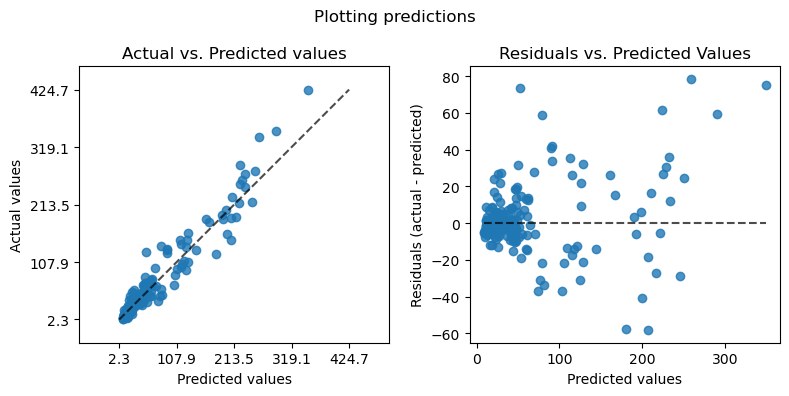

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=axs[0]
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    ax=axs[1]
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting predictions")
plt.tight_layout()
plt.show()

<Axes: xlabel='datetime', ylabel='SPM'>

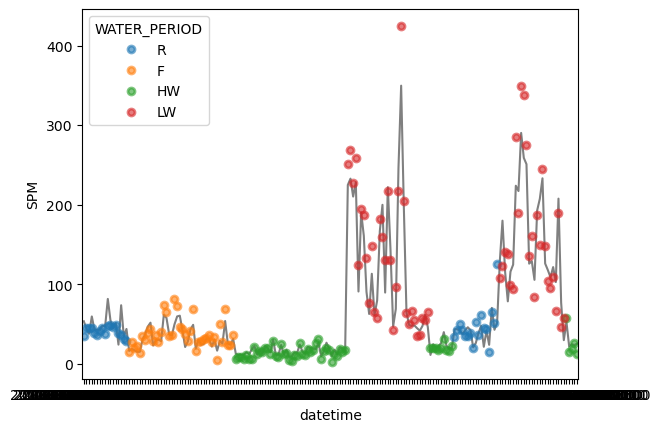

In [19]:
sns.lineplot(data=df_subset, x ='datetime',y= y_pred,color='gray')
sns.pointplot(data=df_subset, x ='datetime',y= y, linestyle="none", markersize=5, alpha=.6,hue='WATER_PERIOD')

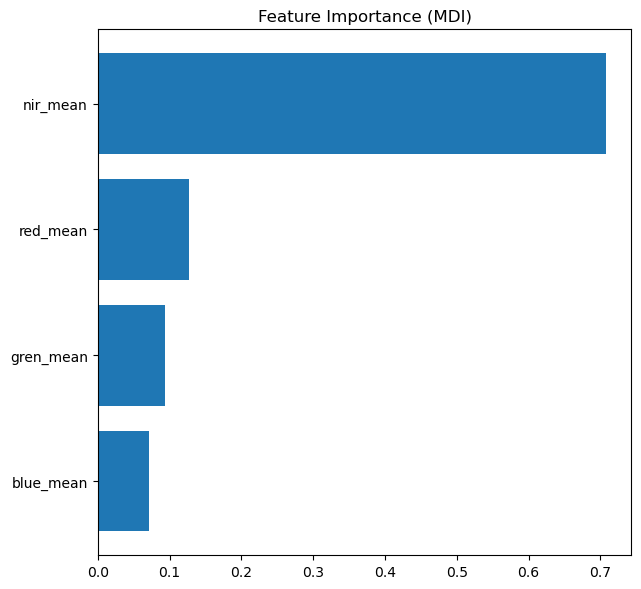

In [20]:
bands = ['blue_mean','gren_mean','red_mean','nir_mean']
feature_importance = rfr_fit.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, bands)
plt.title("Feature Importance (MDI)")

fig.tight_layout()
plt.show()